## Đồ án môn Chuyên đề Xử Lý Ảnh & Video số - Covid19 Project
Họ và tên sinh viên & mssv:

Võ Thành Nam: 20127248
Trần Quốc Hưng: 20127512
Phạm Minh Đức: 20127469


**1. Cài đặt thư viện ****


In [13]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

# Xây dựng, xử lý dữ liệu

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Cài đặt kích thước ảnh và batch size
height, width = 224, 224
batch_size = 64

# Chuẩn bị dữ liệu
def generate_data(DIR, subset=None):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2 if subset in ['training', 'validation'] else None  # Chia nhỏ dữ liệu thành tập train và validation
    )
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',  # phân lại đa lớp sử dụng  'categorical'
        target_size=(height, width),
        subset=subset  # Sử dụng 'subset' để chia dữ liệu thành train và validation
    )
    return generator

# Đường dẫn tới dữ liệu của bạn
TRAIN_VAL_DIR = '../input/covid19-image-dataset/Covid19-dataset/train'
TEST_DIR = '../input/covid19-image-dataset/Covid19-dataset/test'

# Tạo generator cho tập train, validation và test
train_generator = generate_data(TRAIN_VAL_DIR, subset='training')
validation_generator = generate_data(TRAIN_VAL_DIR, subset='validation')
test_generator = generate_data(TEST_DIR)  # Không dùng subset cho test

# Xác định số lượng mẫu trong tập dữ liệu
total_image = np.concatenate([train_generator.labels, validation_generator.labels])

print('\n\n', {
    'Normal_cases': len(np.where(total_image == 0)[0]),
    'Viral_Pneumonia_cases': len(np.where(total_image == 1)[0]),
    'Covid_cases': len(np.where(total_image == 2)[0])
})


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 111, 'Viral_Pneumonia_cases': 70, 'Covid_cases': 70}


# Show một số ảnh dữ liệu 

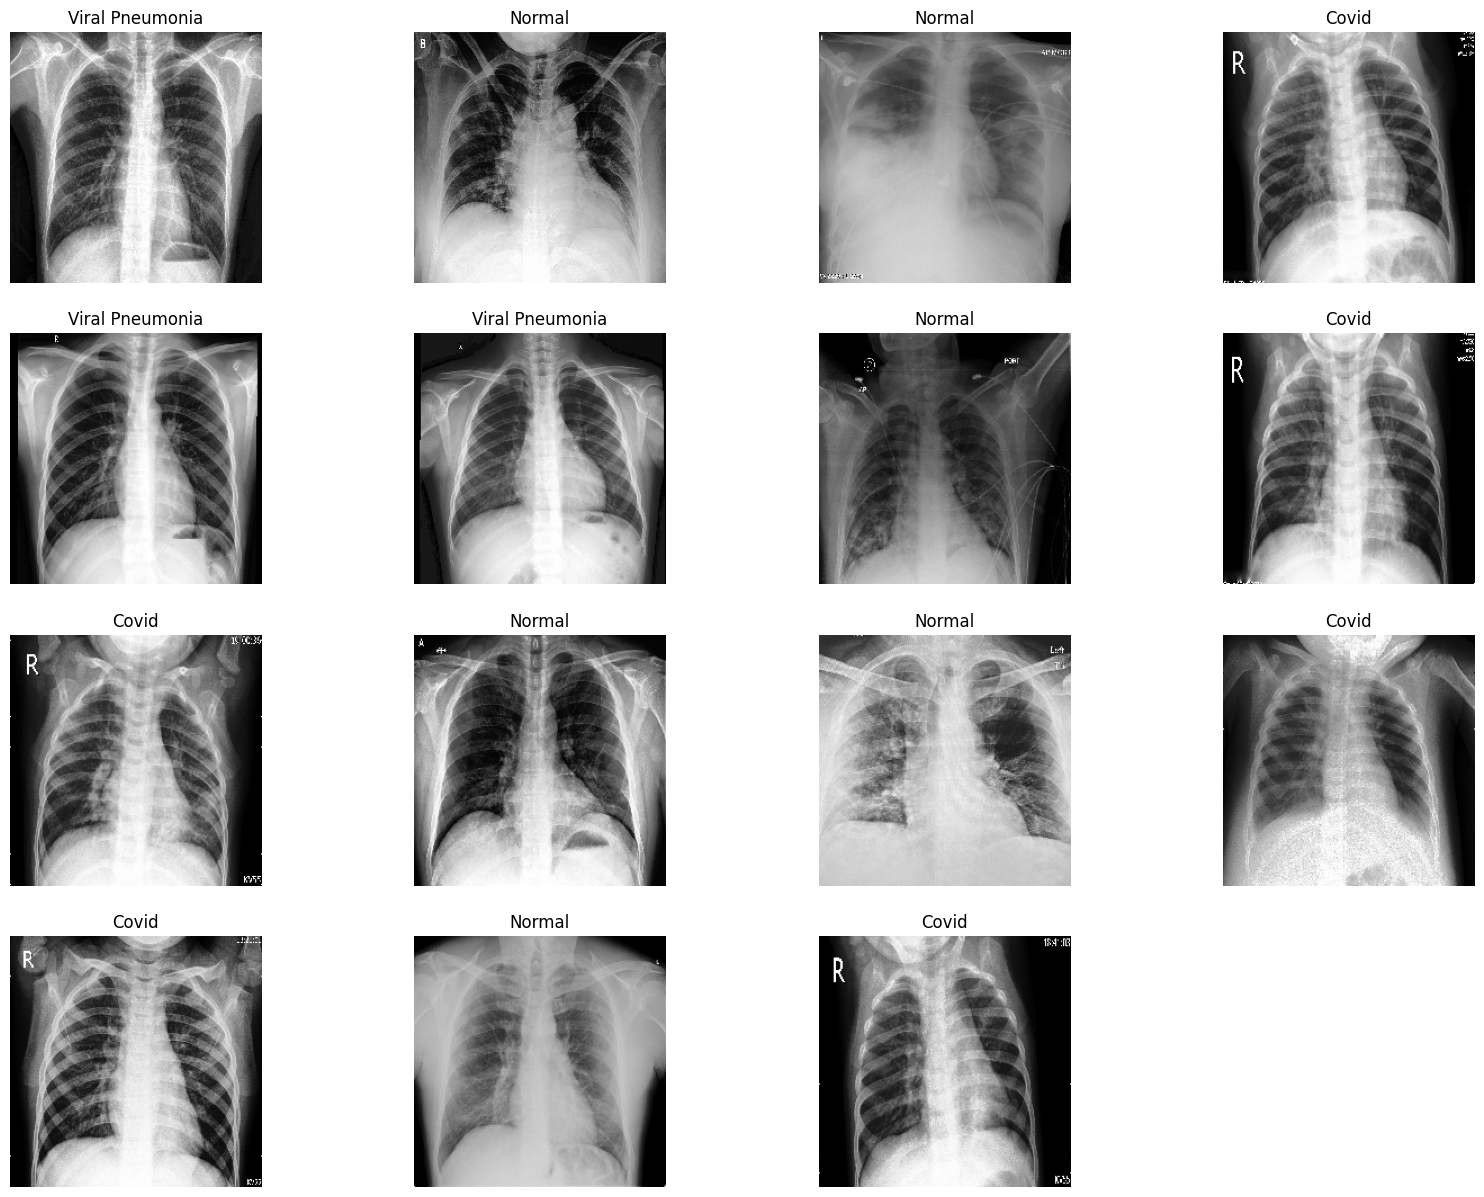

In [15]:
def image_plot(generator, image_numbers):
    # Lấy dữ liệu từ generator
    img_features, img_labels = next(generator)  # Lấy một batch dữ liệu từ generator

    # Giới hạn số lượng ảnh để plot
    img_features = img_features[:image_numbers]
    img_labels = img_labels[:image_numbers]

    # Chuyển đổi nhãn one-hot thành chỉ số lớp
    img_labels = np.argmax(img_labels, axis=1)

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers / 4), 4, i + 1)
        plt.imshow(img_features[i])
        plt.title("Normal" if img_labels[i] == 0 else "Viral Pneumonia" if img_labels[i] == 1 else "Covid")
        plt.axis("off")

    plt.show()

# Sử dụng hàm để plot ảnh từ train_generator
image_plot(train_generator, 15)

# Xây dựng CNN

In [16]:
# Set the default optimizer
default_opt = Adam(learning_rate=0.001)

def get_model():
    model = Sequential()
    # Thêm các lớp Convolutional và MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(height, width, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Thêm các lớp Flatten, Dense và Dropout
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    
    # Lớp đầu ra với số lớp = 3 và activation = softmax
    model.add(Dense(3, activation='softmax'))  # Sử dụng softmax cho phân loại đa lớp
    
    # Biên dịch mô hình
    model.compile(optimizer=default_opt, 
                  loss='categorical_crossentropy',  # Sử dụng categorical_crossentropy cho phân loại đa lớp
                  metrics=['accuracy'])
    
    return model

# Hiển thị cấu trúc mô hình
model = get_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,955,331 (49.42 MB)

 Trainable params: 12,955,331 (49.42 MB)

 Non-trainable params: 0 (0.00 B)

# Huấn luyện mô hình

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.3688 - loss: 13.1271 - val_accuracy: 0.6600 - val_loss: 0.7973
Epoch 2/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.3750 - loss: 31.3086

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3750 - loss: 31.3086 - val_accuracy: 0.4400 - val_loss: 2.4334
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4218 - loss: 15.0941 - val_accuracy: 0.4400 - val_loss: 0.9295
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5156 - loss: 4.8840 - val_accuracy: 0.5400 - val_loss: 0.8699
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.5195 - loss: 2.3819 - val_accuracy: 0.7000 - val_loss: 1.0469
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5556 - loss: 0.9797 - val_accuracy: 0.7800 - val_loss: 1.0526
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5542 - loss: 0.9836 - val_accuracy: 0.6600 - val_loss: 1.0361
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4844 - loss: 0.9784 - val_accuracy: 0.6800 - val_loss: 1.0230
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5437 - loss: 0.9390 - val_accuracy: 0.8200 - val_loss: 0.9698
Epoch 10/70
3/3 ━━━━━

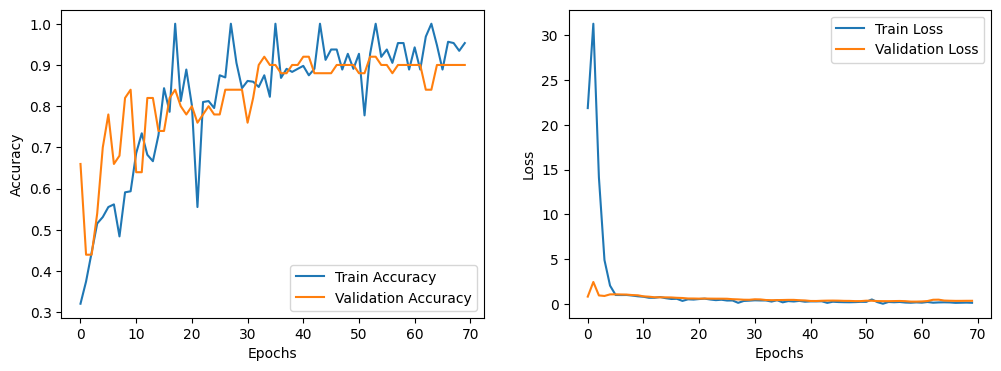

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=70,  # Số lượng epoch, có thể thay đổi để phù hợp với dữ liệu
    verbose=1
)

# Lưu mô hình sau khi huấn luyện
model.save('/kaggle/working/model_covid_classifier.h5')

# Đánh giá mô hình trên tập validation
_, acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=0)
print(f'Model accuracy on validation data: {acc * 100.0:.3f}%')

# Vẽ biểu đồ accuracy và loss theo từng epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Metrid 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        26
         1.0       0.90      0.90      0.90        20
         2.0       0.89      0.85      0.87        20

    accuracy                           0.92        66
   macro avg       0.92      0.92      0.92        66
weighted avg       0.92      0.92      0.92        66



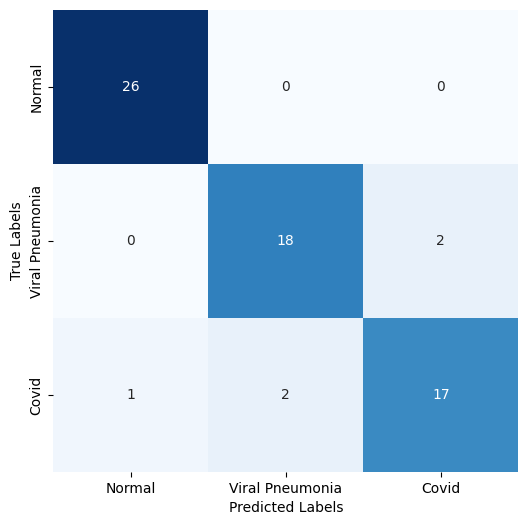

In [18]:
ytest = np.array([])
xtest = []

# Lặp qua các batch trong test_generator
for i in range(math.ceil(len(test_generator.classes) / batch_size)):
    xtest.append(test_generator[i][0])  # Lấy dữ liệu ảnh
    ytest = np.concatenate((ytest, np.argmax(test_generator[i][1], axis=1)))  # Chuyển nhãn từ dạng one-hot về dạng chỉ số lớp

# Nối các mảng lại với nhau
xtest = np.concatenate(xtest, axis=0)

# Dự đoán kết quả trên tập xtest
ypred_prob = model.predict(xtest)
ypred = np.argmax(ypred_prob, axis=1)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

# In báo cáo phân loại
print(classification_report(ytest, ypred))


Show ra các ảnh bị dự đoán sai

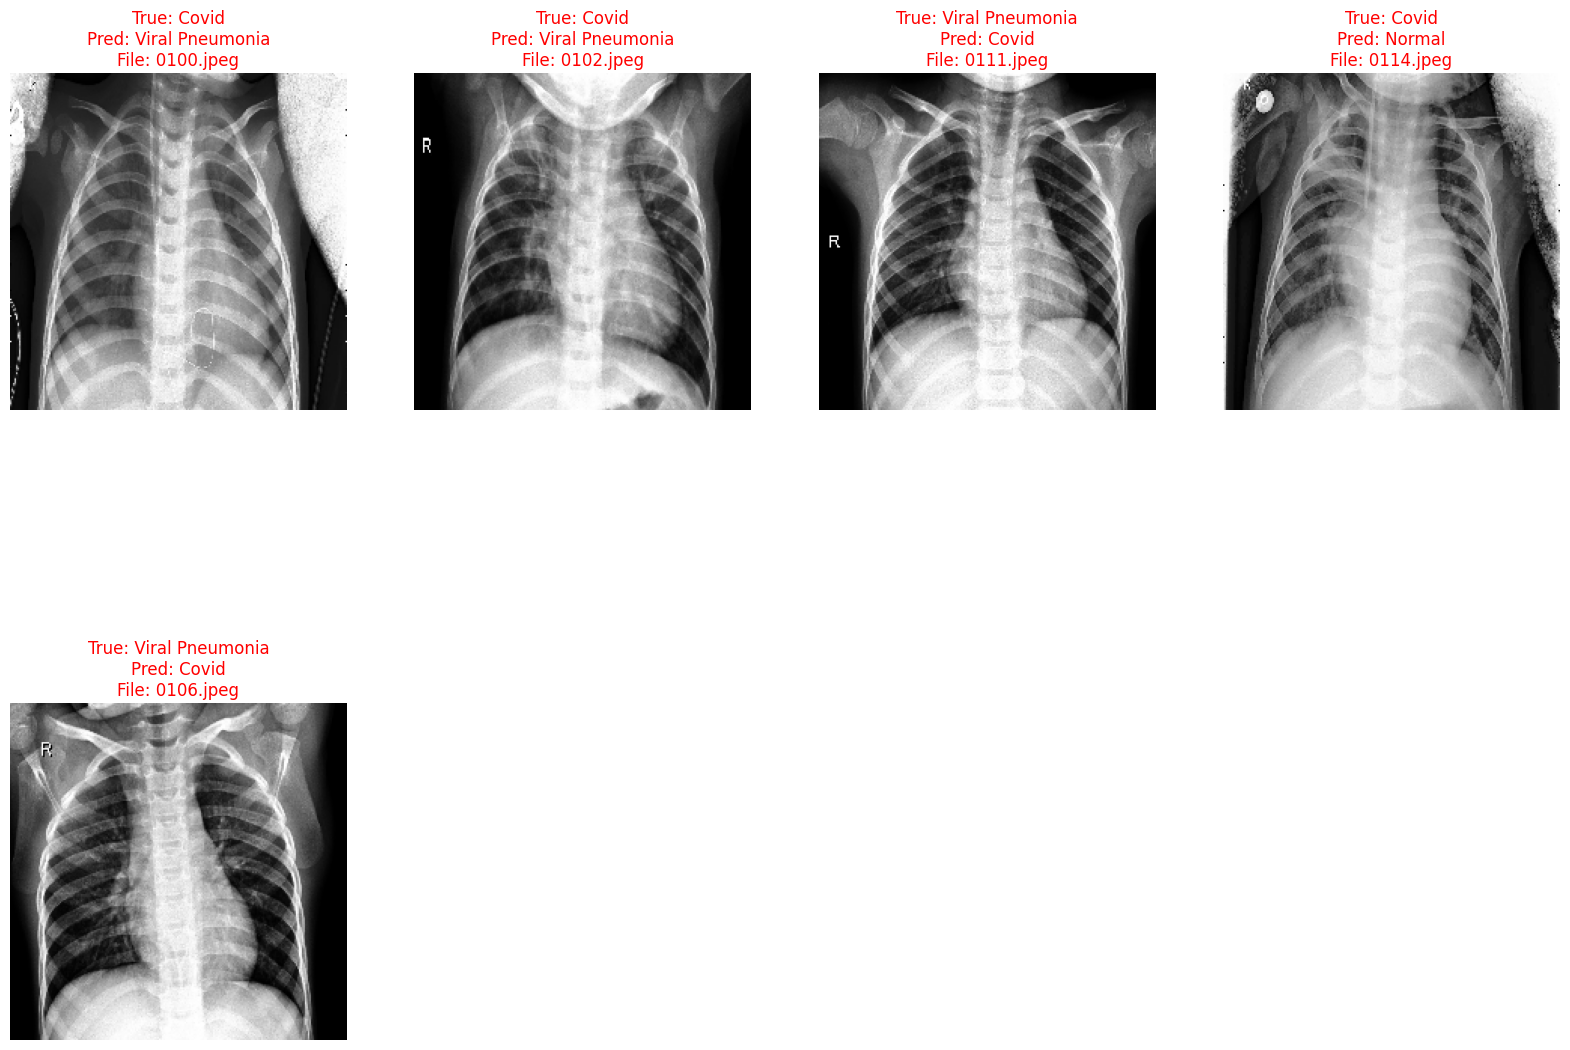

In [19]:
# Extract wrong classification index
wrong_pred = np.where(ypred != ytest)[0]

plt.figure(figsize=(20, 15))
for i, n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred) / 4), 4, i + 1)
    plt.imshow(xtest[n])
    
    # Lấy nhãn thực tế và nhãn dự đoán
    true_label = "Normal" if ytest[n] == 0 else "Viral Pneumonia" if ytest[n] == 1 else "Covid"
    pred_label = "Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid"
    
    # Lấy tên file ảnh
    filename = test_generator.filenames[n].split('/')[-1]  # Lấy tên file từ đường dẫn
    
    # Hiển thị nhãn thực tế, nhãn dự đoán và tên file ảnh
    plt.title(f"True: {true_label}\nPred: {pred_label}\nFile: {filename}", color='red')
    plt.axis("off")

plt.show()


# Tăng cường dữ liệu bằng cách thay đổi tính chất, kích thước ảnh 

In [20]:
# Cài đặt kích thước ảnh và batch size
height, width = 224, 224
batch_size = 64

# Chuẩn bị dữ liệu
def generate_data_augmented(DIR, subset=None):
    datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        validation_split=0.2 if subset in ['training', 'validation'] else None  # Chia nhỏ dữ liệu thành tập train và validation
    )
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',  # Thay đổi từ 'binary' thành 'categorical'
        target_size=(height, width),
        subset=subset  # Sử dụng 'subset' để chia dữ liệu thành train và validation
    )
    return generator

# Đường dẫn tới dữ liệu của bạn
TRAIN_VAL_DIR = '../input/covid19-image-dataset/Covid19-dataset/train'
TEST_DIR = '../input/covid19-image-dataset/Covid19-dataset/test'

# Tạo generator cho tập train, validation và test
train_generator = generate_data(TRAIN_VAL_DIR, subset='training')
validation_generator = generate_data(TRAIN_VAL_DIR, subset='validation')
test_generator = generate_data(TEST_DIR)  # Không dùng subset cho test

# Xác định số lượng mẫu trong tập dữ liệu
total_image = np.concatenate([train_generator.labels, validation_generator.labels])

print('\n\n', {
    'Normal_cases': len(np.where(total_image == 0)[0]),
    'Viral_Pneumonia_cases': len(np.where(total_image == 1)[0]),
    'Covid_cases': len(np.where(total_image == 2)[0])
})

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 111, 'Viral_Pneumonia_cases': 70, 'Covid_cases': 70}


Found 251 images belonging to 3 classes.


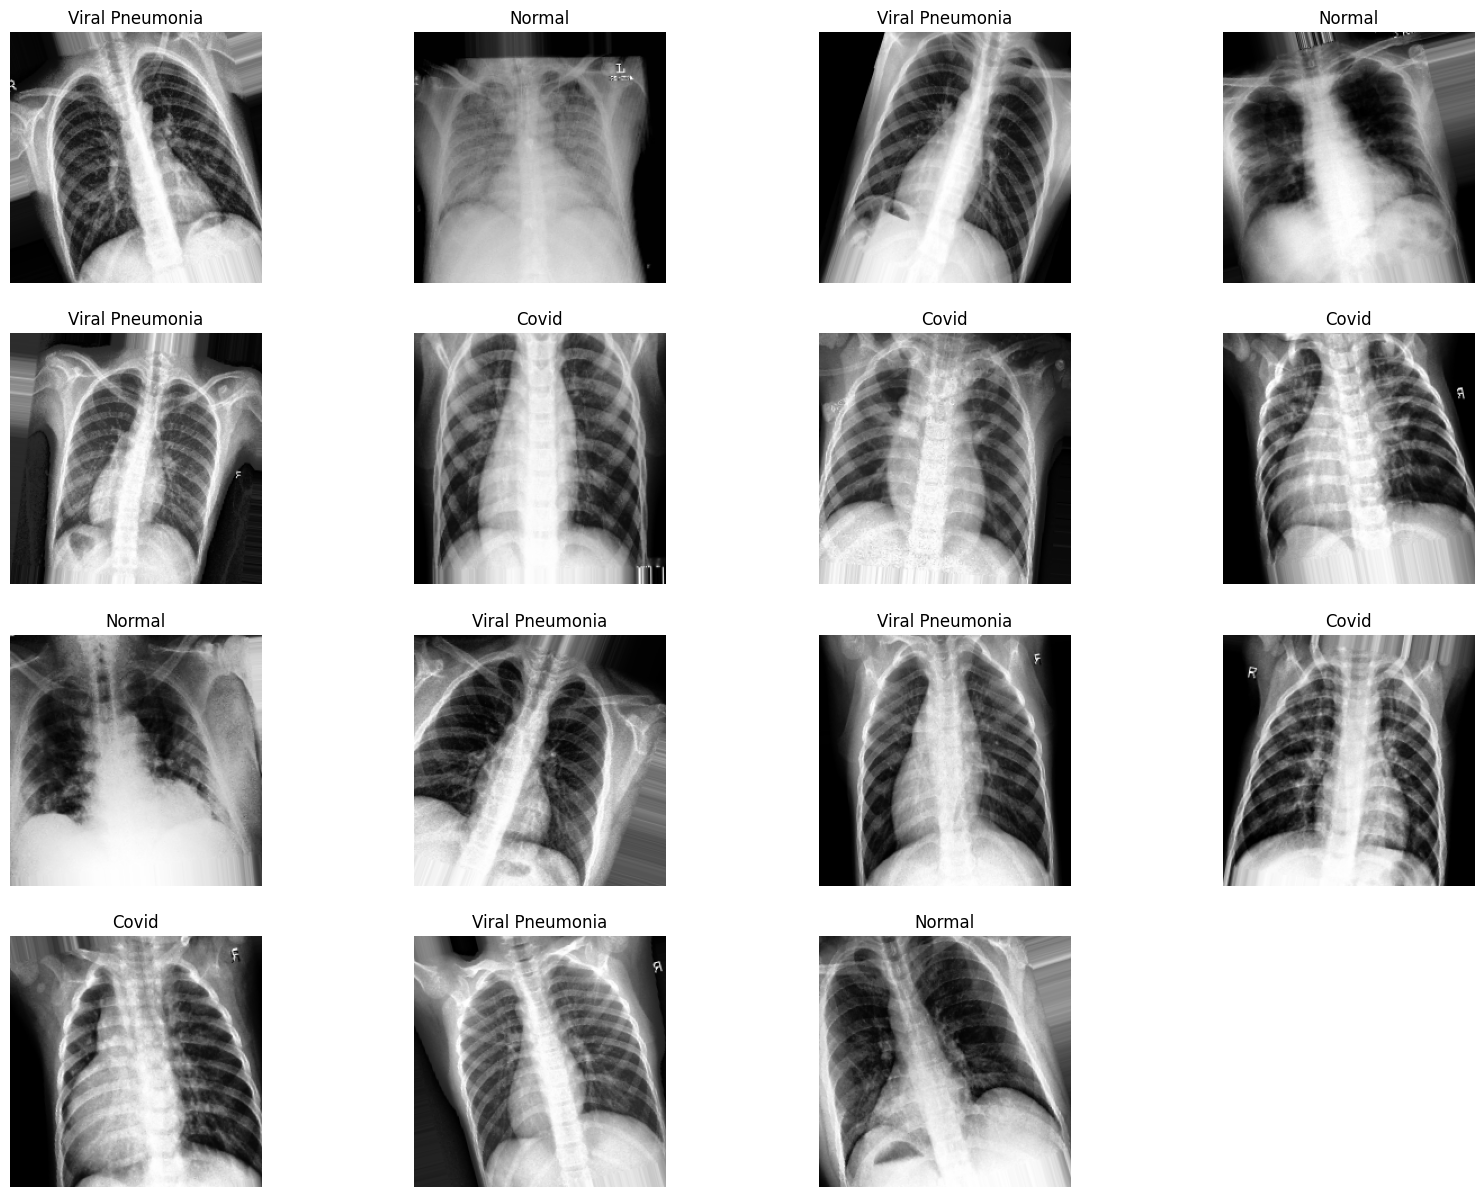

In [21]:
aug_train_generator = generate_data_augmented(TRAIN_VAL_DIR)

image_plot(aug_train_generator,15)


# Huấn luyện lại lần hai

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5974 - loss: 2.2715 - val_accuracy: 0.7600 - val_loss: 0.5563
Epoch 2/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5625 - loss: 1.0809

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5625 - loss: 1.0809 - val_accuracy: 0.7200 - val_loss: 0.5880
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.6715 - loss: 0.7846 - val_accuracy: 0.8800 - val_loss: 0.4165
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7344 - loss: 0.6698 - val_accuracy: 0.9000 - val_loss: 0.4108
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7013 - loss: 0.7019 - val_accuracy: 0.8800 - val_loss: 0.4364
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6875 - loss: 0.6436 - val_accuracy: 0.8800 - val_loss: 0.4470
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.6862 - loss: 0.6843 - val_accuracy: 0.8800 - val_loss: 0.4644
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7797 - loss: 0.5651 - val_accuracy: 0.8800 - val_loss: 0.4619
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.8174 - loss: 0.5649 - val_accuracy: 0.8800 - val_loss: 0.4134
Epoch 10/70
3/3 ━━━━━━━

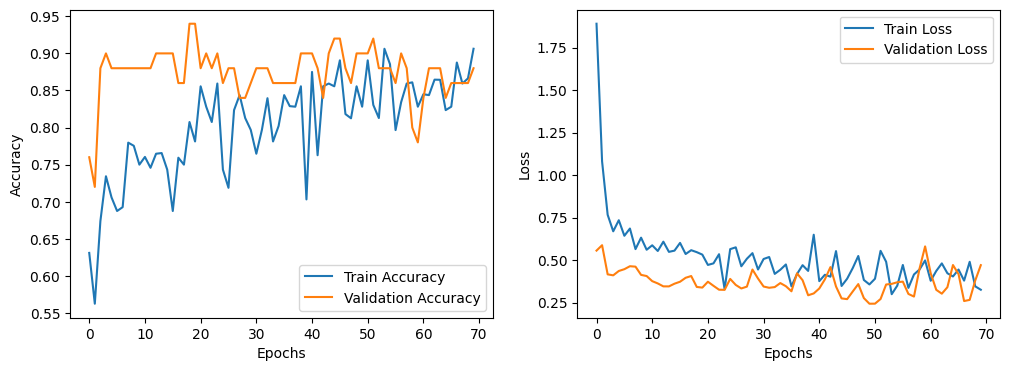

In [22]:
history = model.fit(
    aug_train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=70,  # Số lượng epoch, có thể thay đổi để phù hợp với dữ liệu
    verbose=1
)

# Lưu mô hình sau khi huấn luyện
model.save('/kaggle/working/model_covid_classifier.h5')

# Đánh giá mô hình trên tập validation
_, acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=0)
print(f'Model accuracy on validation data: {acc * 100.0:.3f}%')

# Vẽ biểu đồ accuracy và loss theo từng epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Đánh giá mô hình qua tập train

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        89
         1.0       0.90      0.82      0.86        56
         2.0       0.77      0.98      0.87        56

    accuracy                           0.90       201
   macro avg       0.89      0.90      0.89       201
weighted avg       0.91      0.90      0.90       201



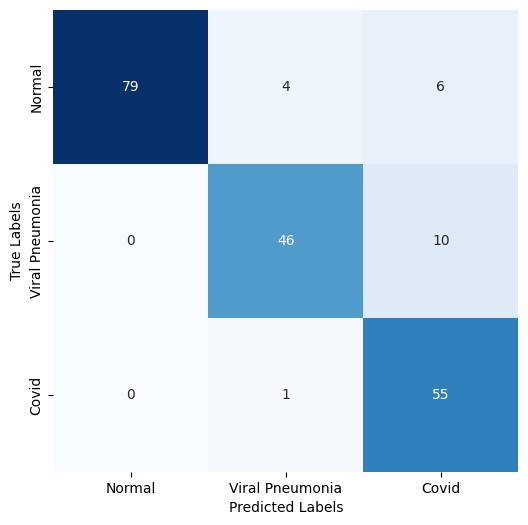

In [23]:
ytrain= np.array([])
xtrain = []

# Lặp qua các batch trong test_generator
for i in range(math.ceil(len(train_generator.classes) / batch_size)):
    xtrain.append(train_generator[i][0])  # Lấy dữ liệu ảnh
    ytrain = np.concatenate((ytrain, np.argmax(train_generator[i][1], axis=1)))  # Chuyển nhãn từ dạng one-hot về dạng chỉ số lớp

# Nối các mảng lại với nhau
xtrain = np.concatenate(xtrain, axis=0)

# Dự đoán kết quả trên tập xtest
ypred_prob = model.predict(xtrain)
ypred = np.argmax(ypred_prob, axis=1)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

# In báo cáo phân loại
print(classification_report(ytrain, ypred))

# Đánh giá mô hình qua tập test

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82        26
         1.0       0.78      0.35      0.48        20
         2.0       0.51      1.00      0.68        20

    accuracy                           0.68        66
   macro avg       0.76      0.68      0.66        66
weighted avg       0.79      0.68      0.67        66



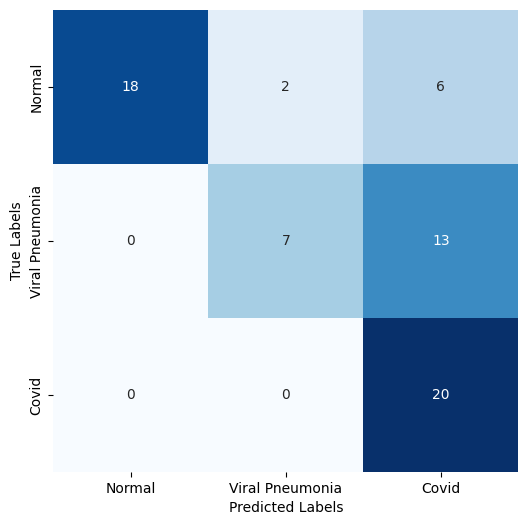

In [24]:
ytest = np.array([])
xtest = []

# Lặp qua các batch trong test_generator
for i in range(math.ceil(len(test_generator.classes) / batch_size)):
    xtest.append(test_generator[i][0])  # Lấy dữ liệu ảnh
    ytest = np.concatenate((ytest, np.argmax(test_generator[i][1], axis=1)))  # Chuyển nhãn từ dạng one-hot về dạng chỉ số lớp

# Nối các mảng lại với nhau
xtest = np.concatenate(xtest, axis=0)

# Dự đoán kết quả trên tập xtest
ypred_prob = model.predict(xtest)
ypred = np.argmax(ypred_prob, axis=1)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

# In báo cáo phân loại
print(classification_report(ytest, ypred))

**Nhận xét: Mô hình khá tốt có thể phân biệt rõ ràng các ảnh có dấu hiệu của bệnh covid 19, chưa phân biệt được rõ ràng các ảnh bị các bệnh về phổi thông thường ****